## Likelihoods we have used:
1. regression: Gaussian
2. count regression: 
    Poisson: lambda=e^f,  Poisson2: lambda=ln(1+e^f)
3. binary classification: 
    Bernoulli: sigmoid,   Bernoulli2: Probit
    
For the sigmoid function, we use **expit** which is provided by *scipy.special*, because it is stable, fast and fairly accurate. Additionally, it is equivalent to sigmoid. For all methods, initial variational parameters are found by running the Laplace approximation on the subset/active set.

In [440]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm,lstsq,cholesky
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from sklearn import preprocessing
import random,time,GPy
from scipy.optimize import minimize
from scipy.special import loggamma,roots_hermitenorm,gamma,expit
from scipy.special import ndtr as std_norm_cdf

_sqrt_2pi = np.sqrt(2*np.pi)
_lim_val = np.finfo(np.float64).max
_lim_val_exp = np.log(_lim_val)

def std_norm_pdf(x): # define a standard normal pdf(from GPy)
    x = np.clip(x,-1e300,1e300)
    return np.exp(-np.square(x)/2)/_sqrt_2pi

def safe_exp(f):
    clip_f = np.clip(f, -np.inf, _lim_val_exp)
    return np.exp(clip_f)

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

def rbf_kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def kernel(X1, X2, *args, **kwargs):
    return rbf_kernel(X1, X2, *args, **kwargs)

def MFE(true_labels, pred_labels):
    '''
    Calculating mean fraction error(MFE) for count regression, the math is used as follows:
    MFE = mean( abs( (true_labels - pred_labels)./true_labels ) ) 
    Written by Kaikai
    '''    
    if true_labels.size != pred_labels.size:
        print('The size of true_labels and pred_labels is supposed to be identical.')
        return -1    
    true_labels = true_labels.flatten().astype('double'); pred_labels = pred_labels.flatten().astype('double')
    true_labels_temp = true_labels.copy()
    if 0 in true_labels: # replace zero with a very small positive value in order to avoid dividing by zero
        print('There are elements of zero value in true labels.')
        true_labels_temp[true_labels==0] = 1
    
    MFE = np.mean( np.abs( (true_labels - pred_labels)/true_labels_temp ) )
    return MFE

def calc_vlb(m,V, a, lik='Gaussian'):
    prior_mean_u = a[0]; prior_mean_f = a[1] # prior mean for inducing points    
    A = a[2] # Knm*inv(Kmm)
    Kmm = a[3]; Kmm_inv = a[4]; Kmn = a[5]; Knn_diag = a[6]; y = a[7] # the ground truth for training data
    noise_var = a[8]
    num_train = len(prior_mean_f);num_inducing = len(prior_mean_u)
    m_q = prior_mean_f + np.dot(A, (m-prior_mean_u)) # Eq.(3a) in paper
    v_q = ( Knn_diag.ravel() + np.diag(np.dot(A, np.dot(V-Kmm, A.T))) )[:, None] # Eq.(3b) in paper
    c1 = m - prior_mean_u; c2 = np.dot(Kmm_inv, c1)
    (Sign,LogDetKmm) = np.linalg.slogdet(Kmm); LogDetKmm = Sign*LogDetKmm
    (SignV,LogDetV) = np.linalg.slogdet(V); LogDetV = SignV*LogDetV;#print(v_q[:50])     
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q));#vlb_lik = expit(y*f);print('yf',expit(y*f))
        vlb_lik = np.sum( 1/_sqrt_2pi*np.dot( safe_ln(expit(y*f)) ,w) ) # sigmoid liklihood
#         vlb_lik = np.sum( 1.0/np.sqrt(2*np.pi)*np.dot( np.log(std_norm_cdf(y*f)+1e-10) ,w) ) # Probit liklihood
    elif lik=='Gaussian':
        vlb_lik = -np.log(np.sqrt(2*np.pi*noise_var)) - np.sum((y-m_q)**2+v_q)/(2*noise_var)
    elif lik=='Poisson':
        vlb_lik = np.dot(y.T,m_q) - np.sum(loggamma(y+1)) - np.sum(np.exp(m_q+0.5*v_q))
    elif lik=='Poisson2': # another link func: lambda=ln(1+e^f)
        f,w = GH_quad(m_q,np.sqrt(v_q));
        term1 = -np.sum(loggamma(y+1)); term2 = -np.sum( 1/_sqrt_2pi*np.dot( np.log(1+safe_exp(f)),w) )
        term3 = np.sum( 1/_sqrt_2pi*np.dot( y*safe_ln(np.log(1+safe_exp(f))),w) )
        vlb_lik = term1 + term2 + term3
    vlb_kl = 0.5*( LogDetKmm - LogDetV + np.dot(c1.T, c2) + np.trace(np.dot(Kmm_inv,V)) - len(prior_mean_u) )
    vlb = vlb_lik - vlb_kl
    return vlb 

def get_init_hyperparameters(Z,Z_label,lik='Poisson'):
    # For all methods, initial variational parameters are found by running the Laplace approximation on the subset/active set.
    dim_data = Z.shape[1]
    kern = GPy.kern.RBF(dim_data, variance=1.0, lengthscale=1.0)
    likelihood = {
          'Poisson': GPy.likelihoods.Poisson(),
          'Poisson2': GPy.likelihoods.Poisson(GPy.likelihoods.link_functions.Log_ex_1()),
          'Gaussian': GPy.likelihoods.Gaussian(),
          'Bernoulli': GPy.likelihoods.Bernoulli()
        }[lik]
    laplace_inf = GPy.inference.latent_function_inference.Laplace()
    model_lap = GPy.core.GP(X=Z, Y=Z_label, likelihood=likelihood, inference_method=laplace_inf, kernel=kern)
    model_lap.optimize()
    print(model_lap)
    return model_lap

def Adam(theta, g_t, t, alpha=0.01, m_t=0, v_t=0, opt='minimize'):
    beta_1 = 0.9; beta_2 = 0.999; epsilon = 1e-8     #initialize the values of the parameters    
    m_t = beta_1*m_t + (1-beta_1)*g_t                #updates the moving averages of the gradient
    v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t)          #updates the moving averages of the squared gradient
    m_cap = m_t/(1-(beta_1**t))                      #calculates the bias-corrected estimates
    v_cap = v_t/(1-(beta_2**t))                      #calculates the bias-corrected estimates
    if opt=='maximize':
        theta = theta + (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)    #updates the parameters
    else:
        theta = theta - (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)    #updates the parameters
    return theta, m_t, v_t

In [441]:
def GH_quad(mu_star,std_star): # gauss_hermite_quad to calculate numerical integration, w and z denote weights and sample points, respectively. 
    z,w = roots_hermitenorm(n=50, mu=False); z,w=z[:,None],w[:,None]
    z = np.kron(std_star,z.T) + mu_star
    return z,w

def predict(X, xStar, l, sigma2, m, V,Kmm,Kmm_inv,y_min=4,y_max=20,noise_var=0.1,lik='Poisson'):
    num_xStar = xStar.shape[0]; Kmn = kernel(X, xStar, l, np.sqrt(sigma2))
    Knn_diag = np.eye(num_xStar)*sigma2+noise_var*np.eye(num_xStar)
    A = np.dot(Kmn.T, Kmm_inv)
    mu_star = np.dot(A,m); v2_star = Knn_diag + np.dot(A, np.dot(V-Kmm,A.T))
    std_star = np.sqrt(np.diag(v2_star))[:,None]
    if lik=='Bernoulli':
        return calc_Bernoulli_pred(mu_star,std_star)
    elif lik=='Gaussian':
        return calc_Gauss_pred(mu_star,std_star,noise_var)
    else: # Poisson, Poisson2
        return calc_Poisson_pred(mu_star,std_star,num_xStar,y_min,y_max,lik)

def calc_Gauss_pred(mu_star,std_star,noise_var):
    return mu_star, std_star+np.sqrt(noise_var)

def calc_Poisson_pred(mu_star,std_star,num_xStar,y_min,y_max,lik='Poisson'):
    f,w = GH_quad(mu_star,std_star)
    y_range = np.arange(y_min,y_max+1)
    lik_func = {
        'Poisson': lambda f,y: 1/gamma(y+1)*safe_exp(-safe_exp(f)+f*y),
        'Poisson2': lambda f,y: 1/gamma(y+1)*expit(-f)*( safe_ln(1.0+safe_exp(f))**y )
    }[lik]
    poisson_lik = np.zeros((num_xStar,len(y_range)))
    for i,y in enumerate(y_range):
        poisson_lik[:,i] = 1/_sqrt_2pi*np.dot(lik_func(f,y),w).ravel()
    return poisson_lik

def calc_Bernoulli_pred(mu_star,std_star):
#     v = std_star**2; kappa_v = (1+np.pi*v/8.0)**(-1/2) # Probit liklihood
#     p = sigmoid(kappa_v*mu_star) # p(y=1|x_*,m,V)
    f,w = GH_quad(mu_star,std_star) # sigmoid liklihood
    p = 1/np.sqrt(2*np.pi)*np.dot( expit(f), w ) # p(y=1|x_*,m,V)
    return p

def calc_m_q(m, A, prior_mean_u, prior_mean_f):
    return prior_mean_f + np.dot(A, (m-prior_mean_u))

def calc_v_q(V, A, Kmm, Knn_diag):
    return ( Knn_diag.ravel() + np.diag(np.dot(A, np.dot(V-Kmm, A.T))) )[:,None] # Eq.(3b) in paper

def calc_rho(m_q, v_q, y, lik='Poisson', noise_var=0.1):
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        return 1.0/_sqrt_2pi*np.dot(  y*expit(-y*f) , w ) # sigmoid liklihood
#         return 1.0/_sqrt_2pi*np.dot( y*std_norm_pdf(f) / (std_norm_cdf(y*f)+1e-10), w ) # Probit liklihood        
    elif lik=='Gaussian':
        return 1.0/noise_var*(y-m_q)
    elif lik=='Poisson':
        return -np.exp(m_q + 0.5*v_q) + y
    elif lik=='Poisson2':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        y = np.tile(y,[1,f.shape[1]]); term2 = expit(f); t0 = safe_ln(1+safe_exp(f))# avoid dividing by zeros
        d1_log_lik = np.zeros(t0.shape)
        d1_log_lik[t0!=0] = (y[t0!=0]/t0[t0!=0] - 1)*term2[t0!=0]
        return 1.0/_sqrt_2pi*np.dot(  d1_log_lik, w )
    
def calc_lambda(m_q, v_q, y, lik='Poisson', noise_var=0.1):
    if lik=='Bernoulli':
        f,w = GH_quad(m_q,np.sqrt(v_q))
        return 1.0/np.sqrt(2*np.pi)*np.dot(  -expit(y*f)*expit(-y*f), w ) # sigmoid
#         return 1.0/_sqrt_2pi*np.dot( -std_norm_pdf(f)**2 / (std_norm_cdf(y*f)**2+1e-10) - y*f*std_norm_pdf(f) / (std_norm_cdf(y*f)+1e-10), w )
    elif lik=='Gaussian':
        return -1.0/noise_var*np.ones((len(m_q),1))
    elif lik=='Poisson':
        return -np.exp(m_q + 0.5*v_q)
    elif lik=='Poisson2':
        f,w = GH_quad(m_q,np.sqrt(v_q));y = np.tile(y,[1,f.shape[1]]);
        term2 = expit(f)*expit(f); t0 = safe_ln(1+safe_exp(f));d2_log_lik = np.zeros(t0.shape)
        d2_log_lik[t0!=0] = ((y[t0!=0]/t0[t0!=0]-1)*safe_exp(-f[t0!=0])-y[t0!=0]/(t0[t0!=0])**2)*term2[t0!=0]
        return 1.0/_sqrt_2pi*np.dot(  d2_log_lik, w )

def dVLb_dm(m, rho, prior_mean_u, Kmm_inv, A):
    dm = np.dot(A.T,rho) - np.dot(Kmm_inv, m-prior_mean_u) # Eq.(11a) in paper
    return dm

def dVLb_dL(L, lam, Kmm_inv, A, noise_var=1e-8):# optimizing the cholesky factor L guarantees the PSD of V automatically
    dL = np.dot( np.dot( np.dot(A.T, np.diag(lam.ravel())), A ), L ) + inv(L+np.sqrt(noise_var)*np.eye(len(L))).T - np.dot(Kmm_inv, L)
    return dL

In [486]:
def Train(X,Y,ix,X_test=None,y_test=None,max_iter=100,lr=1*10**-5,FPb_cond=1*10**-1,stop_cond=1*10**-3,VLB_opt='GD',lik='Poisson'):
    num_train = X.shape[0];num_inducing=len(ix);num_test=X_test.shape[0]; 
    prior_mean_u = np.zeros((num_inducing, 1)); prior_mean_f = np.zeros((num_train, 1))
    Z = X[ix, :]; Z_label = Y[ix] # Z is the inducing set
    model_lap = get_init_hyperparameters(Z,Z_label,lik=lik)#(Z_label+1)/2    
    # variational parameters from initialization
    f_mean, f_var = model_lap._raw_predict(X) 
    length_scale = model_lap.rbf.lengthscale[0]; sigma2 = model_lap.rbf.variance[0];
    if lik=='Gaussian': noise_var=model_lap.Gaussian_noise.variance[0] 
    else: noise_var=1*10**-8
    #  we use variational mean from Laplace appr
    m = f_mean[ix]; V = np.diag(f_var[ix].ravel()); L = cholesky(V)
    Kmm = kernel(Z, Z, l = length_scale, sigma_f = np.sqrt(sigma2)) + noise_var*np.eye(len(Z))
    Kmm_inv = inv(Kmm); Kmn = kernel(Z, X, l = length_scale, sigma_f = np.sqrt(sigma2)); Knn_diag = sigma2*np.ones((num_train, 1))
    A = np.dot(Kmn.T, Kmm_inv) # Knm*inv(Kmm)    
    a = (prior_mean_u,prior_mean_f,A,Kmm,Kmm_inv,Kmn,Knn_diag,Y,noise_var)
    num_iter = 0; VLB = []; VLB_time = []; err = []; FPb_converge = True
    var = np.hstack([m.flatten(), L.flatten()])
    start_time = time.time(); VLB.append(-calc_vlb(m,V, a,lik)[0][0])
    if lik=='Poisson' or lik=='Poisson2':
        y_min = min(Y); y_max = max(Y)
        poisson_lik = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,y_min=y_min,y_max=y_max,noise_var=noise_var,lik=lik)
        res = np.argmax(poisson_lik, axis=1)+y_min; err.append( MFE(y_test, res) )
    elif lik=='Gaussian':
        mu_star, std_star = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik)
        err.append( 1/num_test*( np.sum( (y_test-mu_star)**2 ) ) )
    elif lik=='Bernoulli':
        p = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik); 
        res = np.where(p>=0.5,1,-1)
        err.append( np.sum( np.where(y_test*res<0,1,0) )/num_test );print('err:', err)
    VLB_time.append(time.time()-start_time);
    while 1:
        num_iter = num_iter +1;
        m_q = calc_m_q(m, A, prior_mean_u, prior_mean_f); v_q = calc_v_q(V, A, Kmm, Knn_diag);#print('m_q:',m_q[:10])
        # According to Table 1 in paper, expectations of the derivatives wrt N(f|m,v) for Possion likelihood
        rho = calc_rho(m_q, v_q, Y,lik, noise_var); lam = calc_lambda(m_q, v_q,Y,lik, noise_var);        
        if VLB_opt=='GD':
            dm = dVLb_dm(m, rho, prior_mean_u, Kmm_inv, A)
            dL = dVLb_dL(L, lam, Kmm_inv, A, noise_var)
            gradients = np.hstack([dm.flatten(), dL.flatten()])
            var, m_t, v_t = Adam(var,gradients,num_iter,alpha=lr,opt='maximize')
            m = var[:num_inducing][:,None] # variantional mean
            L = var[num_inducing:].reshape(num_inducing,num_inducing) # variational variance V=L*L.T
            V = np.dot(L, L.T);
            
        elif VLB_opt=='FPi':
            dm = dVLb_dm(m, rho, prior_mean_u, Kmm_inv, A)
            m, m_t, v_t = Adam(m,dm,num_iter,alpha=lr,opt='maximize') # print('old V',V[:1,:1])
            V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A ));
        elif VLB_opt=='FPb':            
            if FPb_converge:
                dm = dVLb_dm(m, rho, prior_mean_u, Kmm_inv, A); print('old m:',m[:2]);
                m, m_t, v_t = Adam(m,dm,num_iter,alpha=lr,opt='maximize')
            else:
                V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A))
                
        elif VLB_opt=='FPi-mean':
            d = A.T; gamma = -lam; # print('old m:',m[:2]);            
            m = np.dot(V, np.dot(d, rho + np.dot(A,m)*gamma) ); 
            V = inv(Kmm_inv-np.dot( np.dot(A.T, np.diag(lam.ravel())), A))

        VLB.append(-calc_vlb(m,V, a,lik)[0][0]); VLB_time.append(time.time()-start_time)
        if lik=='Poisson' or lik=='Poisson2':
            poisson_lik = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,y_min=y_min,y_max=y_max,noise_var=noise_var,lik=lik)
            res = np.argmax(poisson_lik, axis=1)+y_min; err.append( MFE(y_test, res) )
        elif lik=='Gaussian':
            mu_star, std_star = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik)
            err.append( 1/num_test*( np.sum( (y_test-mu_star)**2 ) ) )
        elif lik=='Bernoulli':
            p = predict(Z, X_test, length_scale, sigma2, m, V,Kmm,Kmm_inv,noise_var=noise_var,lik=lik); res = np.where(p>=0.5,1,-1)
            err.append( np.sum( np.where(y_test*res<0,1,0) )/num_test );
        if num_iter>0:
            delta_vlb = abs(VLB[-1]-VLB[-2])
            if VLB_opt=='FPb' and delta_vlb<=FPb_cond:
                FPb_converge = not FPb_converge; print('m or V converged')
            if num_iter>=5 and delta_vlb<=stop_cond:
                print('After {} iterations it converged: delta_VLB:{:.6f}, VLB:{:.6f}, err:{:.6f}'.format(num_iter,delta_vlb,VLB[-1],err[-1]) );break                
            if num_iter==max_iter:
                print('It has reached the maximum number of iterations, i.e. {}, with delta_VLB:{:.6f}, VLB:{:.6f} and err:{:.6f}'.format(max_iter,delta_vlb,VLB[-1],err[-1]));break
            if num_iter%5 == 0:
                print('iter:{}, delta_VLB:{:.6f}, VLB:{:.6f}, err:{:.6f}'.format(num_iter, delta_vlb, VLB[-1], err[-1]));
            
    return Z,Z_label, VLB, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv, A,VLB_time,err

In [490]:
GD = Train(X_train,y_train,ix,X_test,y_test,max_iter=200,lr=2*10**-3,VLB_opt='GD',lik='Bernoulli');
Zs,Zs_label, VLB, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time,err = GD


Name : gp
Objective : 43.6836449900548
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |   7.050465253450157  |      +ve      |        
  rbf.lengthscale  |  0.6631713194475982  |      +ve      |        
err: [0.18521739130434783]
iter:5, delta_VLB=2390238.822964, VLB: 128652061.744649, err: 0.185217
iter:10, delta_VLB=1887573.838554, VLB: 118454868.597162, err: 0.183913
iter:15, delta_VLB=1687985.971080, VLB: 109673442.017752, err: 0.182609
iter:20, delta_VLB=1597009.009117, VLB: 101523561.263213, err: 0.183043
iter:25, delta_VLB=1512990.624108, VLB: 93795730.345453, err: 0.181739
iter:30, delta_VLB=1454712.953930, VLB: 86409602.349504, err: 0.181739
iter:35, delta_VLB=1376033.854687, VLB: 79376649.450643, err: 0.179565
iter:40, delta_VLB=1310601.749983, VLB: 72696877.969324, err: 0.180000
iter:45, delta_VLB=1227684.673608, VLB: 66395579.781535, err: 0.1782

In [479]:
Zs,Zs_label, VLB_FPi, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time_FPi,err_FPi = Train(X_train,y_train,ix,X_test,y_test,max_iter=50,lr=2*10**-4,VLB_opt='FPi',lik='Bernoulli')


Name : gp
Objective : 43.6836449900548
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |   7.050465253450157  |      +ve      |        
  rbf.lengthscale  |  0.6631713194475982  |      +ve      |        
err: [0.18521739130434783]
old m: [[-0.70346524]
 [-2.45772837]]
old m: [[-0.70366524]
 [-2.45792837]]
old m: [[-0.70381406]
 [-2.4580772 ]]
old m: [[-0.70394183]
 [-2.45820496]]
old m: [[-0.70405805]
 [-2.45832119]]
iter: 5, variation_VLB=11.375079, VLB: 145364565.180929
err: 0.18565217391304348
old m: [[-0.70416715]
 [-2.45843028]]
old m: [[-0.70427157]
 [-2.45853471]]
old m: [[-0.70437285]
 [-2.45863598]]
old m: [[-0.704472  ]
 [-2.45873513]]
old m: [[-0.70456975]
 [-2.45883288]]
iter: 10, variation_VLB=6.913691, VLB: 145364603.978440
err: 0.18608695652173912
old m: [[-0.70466663]
 [-2.45892977]]
old m: [[-0.70476306]
 [-2.4590262 ]]
old m: [[-0.70485935]

In [ ]:
Zs,Zs_label, VLB_FPi, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time_FPi,err_FPi = Train(X_train,y_train,ix,X_test,y_test,max_iter=50,lr=2*10**-4,VLB_opt='FPi',lik='Bernoulli')

In [ ]:
Zs,Zs_label, VLB_FPi, length_scale, sigma2, m, V,noise_var, Kmm, Kmm_inv,A,VLB_time_FPi,err_FPi = Train(X_train,y_train,ix,X_test,y_test,max_iter=50,lr=2*10**-4,VLB_opt='FPi-mean',lik='Bernoulli')

In [14]:
# Make some 1D training data(regression)
num_train = 2000;num_test=700                         # 500 training poitns
X_train = np.linspace(0, 10, num_train)[:,None]       # Inputs evenly spaced between 0 and 10
F = np.sin(X_train)                   # True function (f = sin(x))
y_train = F + 0.01*np.random.randn(num_train)[:,None]  # Observations
X_test = np.linspace(0, 10, num_test)[:,None]       # Inputs evenly spaced between 0 and 10
F_test = np.sin(X_test)                   # True function (f = sin(x))
y_test = F_test + 0.01*np.random.randn(num_test)[:,None]  # Observations
np.random.seed(3);num_inducing=100
ix = random.sample(range(num_train), num_inducing)

In [15]:
y_train = np.where(y_train >= 0, 1, -1); y_test = np.where(y_test >= 0, 1, -1)

In [218]:
# load data(count regression)
mat_contents = sio.loadmat('count_dataset_ucsdpeds1l_N4000_D30.mat')
x = mat_contents['x']; y = mat_contents['y']
x = x.astype('double')

# shuffle the data and split data into training set and test set
data = np.concatenate((x,y), axis=1)
np.random.shuffle(data)
num_data = data.shape[0]; dim_data = data.shape[1] - 1;
num_train = int(0.5*np.ceil(num_data)); num_test = num_data - num_train
x_train = data[:num_train, :-1]; y_train = data[:num_train, -1];
x_test = data[num_train:, :-1]; y_test = data[num_train:, -1];
y_train = y_train[:, None]; y_test = y_test[:, None]
# data Standardization with zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(x_train)
X_train = scaler.transform(x_train); X_test = scaler.transform(x_test)
np.random.seed(3);num_inducing=100
ix = random.sample(range(num_train), num_inducing)

In [ ]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1

# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], data[:,-1][:, None]

# We will plot our data as well
plt.figure(figsize=(8,8))

# Plot 0 class in blue
plt.plot(X[np.where(y == -1),0],X[np.where(y == -1),1],'bo', mew=0.5, alpha=0.5)
# Plot 1 class in red
plt.plot(X[np.where(y == 1),0],X[np.where(y == 1),1],'ro', mew=0.5, alpha=0.5)

# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Banana Dataset (red=1, blue=0)")
plt.axis("square"), plt.xlim((-3, 3)), plt.ylim((-3, 3));

In [476]:
# Load data from file, make sure banana.csv is in the same directory as this notebook
data = np.genfromtxt('banana.csv', delimiter=',')

# Dimension of data
D = data.shape[1]-1
n = data.shape[0]
# Seperate our data (input) from its corresponding label output
# .. note we have to rescale from [-1,1] to [0,1] for a Bernoulli distribution
X, y = data[:,:D], data[:,-1][:, None]
num_train = 3000; num_test = n - num_train
X_train, y_train = X[:num_train,:], y[:num_train]
X_test, y_test = X[:num_test,:], y[:num_test]
np.random.seed(3);num_inducing=100 # randomly select active set and then keep them fixed
ix = random.sample(range(num_train), num_inducing)

[-40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23
 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5
  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13
  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 5.72557122e-300
 4.18262407e-284 1.12491071e-268 1.11389879e-253 4.06118562e-239
 5.45208060e-225 2.69525008e-211 4.90671393e-198 3.28978527e-185
 8.12386947e-173 7.38948101e-161 2.47606332e-149 3.05669671e-138
 1.39039212e-127 2.33063701e-117 1.43989244e-107 3.27927802e-098
 2.75362412e-089 8.52722395e-081 9.74094892e-073 4.10599620e-065
 6.38875440e-058 3.67096620e-051 7.79353682e-045 6.11716440e-039
 1.77648211e-033 1.91065957e-028 7.61985302e-024 1.12858841e-019
 6.22096057e-016 1.27981254e-012 9.86587645e-010 2.86651572e-007
 3.16712418e-005 1.34989803e-003 2.27501319e-002 1.58655254e-001
 5.00000000e-001 8.41344

 C:\Users\kevin\AppData\Local\conda\conda\envs\graph_analytics\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:divide by zero encountered in true_divide
 C:\Users\kevin\AppData\Local\conda\conda\envs\graph_analytics\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in true_divide


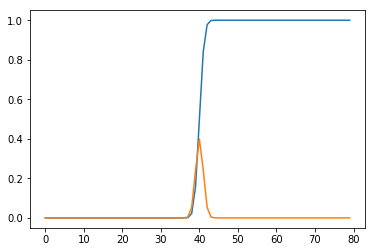

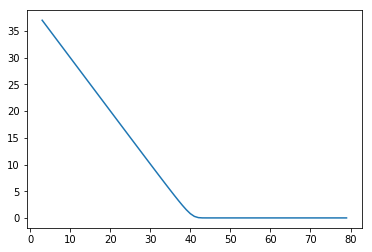

In [475]:
from scipy.stats import norm
num = np.arange(-39,40);print(num)
plt.figure(1)
a1 = norm.cdf(num);print(a1)
a2 = norm.pdf(num);print(a2)
plt.plot(a1)
plt.plot(a2)
plt.figure(2)
r = norm.pdf(num)/norm.cdf(num)
plt.plot(r);print(r.shape)
print(r)

In [463]:
norm.pdf(-30)

1.4736461348785476e-196

In [ ]:
aa=np.random.randn(4,2);cc=np.ones((4,2))*10;print(aa)
bb=np.arange(4)[:,None];print(bb)
bb=np.tile(bb,[1,2]);print(bb.shape)
term1=np.zeros((4,2))
term1[bb!=0]=(aa[bb!=0]/cc[bb!=0])
print(term1)
# a1=np.where(bb==0,0,term1);print('a1',a1)

In [ ]:
np.all(np.linalg.eigvals(V) > 0)# check PSD condition for V

In [ ]:
result = {
  'a': lambda x: x * 5,
  'b': lambda x: x + 7,
  'c': lambda x: x - 2
}[value](x)